In [133]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:
def adjustDataframe(dataFrame):
    # dataFrame['Sex'] = np.where(dataFrame['Sex']=='female',1,0)
##  Get name prefix
    namePrefix = dataFrame["Name"].str.split(', ', 1).str[1]
    namePrefix = namePrefix.str.split('. ',1).str[0]
    dataFrame["NamePrefix"] = namePrefix
##  Split ticket into numeric and prefix parts
    spacedTicket = ' ' + dataFrame['Ticket'].astype(str)
    ticketSplit = spacedTicket.str.rsplit(' ',1,expand=True)
    dataFrame["TicketPrefix"] = ticketSplit[0]
    dataFrame["TicketPrefix"] = dataFrame["TicketPrefix"].str.replace(".","")
    dataFrame["TicketPrefix"] = dataFrame["TicketPrefix"].str.replace(" ","")
    dataFrame["TicketNumber"] = ticketSplit[1]  
#Check if there were NaN for those columns
    dataFrame["FamilySize"] = dataFrame["SibSp"] + dataFrame["Parch"]  + 1

## There are multiple cabins per some of passengers - how to proceed?
# For now I will only use deck name and amount of cabins. For later I should check how could I use multiple entries
    dataFrame["CabinDeck"] = dataFrame["Cabin"].str[:1]
    dataFrame["CabinsAmount"] = dataFrame["Cabin"].str.split(" ",-1).str.len()

    del namePrefix, spacedTicket, ticketSplit
    dataFrame.drop(["Name", "Ticket", "Cabin"], axis=1, inplace=True)
    return dataFrame

In [135]:
def extract_columns(columns, dropColumn=None):
    yColumn = "Survived"
    dfTrain = pd.read_csv("./train.csv")
    dfTest = pd.read_csv("./test.csv")

    y = dfTrain[yColumn]
    dfTrain.drop(yColumn, axis=1, inplace=True)
    X_full = dfTrain.append(dfTest, ignore_index=True)
    #   Enhance dataframe with additional columns
    X_full = adjustDataframe(X_full)
    # Fill nan values
    X_full = X_full.replace(r'^\s*$', np.nan, regex=True)
    # Impute nan to mean and encode categorical data into separate columns
    numericColumns, categoricalColumns = getValidColumns(columns)
    mean_Imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X_numeric = mean_Imputer.fit_transform(X_full[numericColumns])
    X_numeric = StandardScaler().fit_transform(X_numeric)
    categorical_data = X_full[categoricalColumns].fillna("N/A").astype(str)
    oneHotEncoder = OneHotEncoder(sparse = False,drop=dropColumn)
    X_categorical = oneHotEncoder.fit_transform(categorical_data)
    encodedColumns = list(oneHotEncoder.get_feature_names())
    columnNames = numericColumns
    columnNames.extend(encodedColumns)
    # Split data back to train and test
    X_train = np.hstack((X_numeric[0:891,:],X_categorical[0:891,:]))
    X_final_test = np.hstack((X_numeric[891:1309,:],X_categorical[891:1309,:]))
    return X_train, X_final_test, y, columnNames

In [136]:
# build column list
def getValidColumns(columns):
    allNumericColumns = ["Pclass", "Age", "FamilySize", "Fare", "CabinsAmount"]
    allCategoricalColumns = ["Sex","NamePrefix", "TicketPrefix", "CabinDeck", "Embarked"]
    numColumns = []
    catColumns = []

    for column in columns:
        if column in allNumericColumns:
            numColumns.append(column)
        if column in allCategoricalColumns:
            catColumns.append(column)
    return numColumns, catColumns


In [137]:
used_columns= ["Pclass", "Age", "FamilySize", "Fare", "CabinsAmount","Sex", "NamePrefix"]
X_train, X_test, y, columnNames = extract_columns(used_columns)
columnsAmount = X_train.shape[1]
for column in range(columnsAmount):
    print(columnNames[column], ", coef: ",round(np.corrcoef(X_train[:, column], y) [1,0],3))


Pclass , coef:  -0.338
Age , coef:  -0.07
FamilySize , coef:  0.017
Fare , coef:  0.257
CabinsAmount , coef:  -0.038
x0_female , coef:  0.543
x0_male , coef:  -0.543
x1_Capt , coef:  -0.026
x1_Col , coef:  0.011
x1_Don , coef:  -0.026
x1_Dona , coef:  nan
x1_Dr , coef:  0.008
x1_Jonkheer , coef:  -0.026
x1_Lady , coef:  0.042
x1_Major , coef:  0.011
x1_Master , coef:  0.085
x1_Miss , coef:  0.327
x1_Mlle , coef:  0.06
x1_Mme , coef:  0.042
x1_Mr , coef:  -0.549
x1_Mrs , coef:  0.339
x1_Ms , coef:  0.042
x1_Rev , coef:  -0.065
x1_Sir , coef:  0.042
x1_th , coef:  0.042


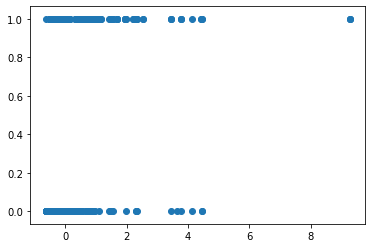

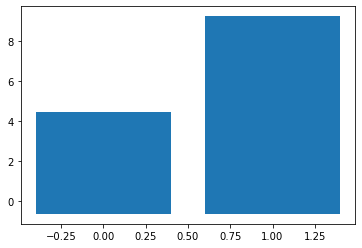

In [146]:
# sns.factorplot("Age", "Sex", data=X_train, kind="box")
plt.scatter(X_train[:,3],y)
plt.show()
plt.bar(y,X_train[:,3])
plt.show()